# QR Timecode for Time Synchronization

## Disclaimer

This QR code generator is a derivative work of [https://github.com/gopro/labs/tree/master/docs/qr](https://github.com/gopro/labs/tree/master/docs/qr).

## Overview

Suppose you want to find "corresponding" frames from videos captured by freely-running cameras, by burning timecodes into your video footage.  This sample provides a QR code generator to be captured by the cameras, a script to detect the QR codes in the captured video, and a script to estimate their relative offsets.

Note that the offsets are given as floating-point numbers, meaning that the "corresponding" frames are off by subframes.  In order to get frames that are exactly synchronized, i.e. that their exposures start at exactly the same time, we need to use a trigger or Genlock signal.


MP4 has a timestamp in its metadata.  [If your camera clocks are synchronized to a single reference](https://gopro.github.io/labs/control/precisiontime/), the offset can be calculated directly from the metadata.  This QR code can serve as a backup / second source of synchronization.

## Usage

1. Open [`../data/qrtimecode/qrtimecode+js.html`](../data/qrtimecode/qrtimecode+js.html) on your smartphone (or laptop, tablet, etc.) $S$. Be sure that $S$ shows a time-varying QR code.
   - The QR code encodes the current timestamp (up to the millisecond) in GoPro format.
2. (Optional, GoPro only) Show $S$ to your GoPro cameras to [synchronize their clocks](https://gopro.github.io/labs/control/precisiontime/).
3. For each $C_i$ of your cameras $C_1$, $C_2$, ...
   1. Start recording.
   2. Show $S$ to $C_i$ for a few seconds.
   3. Leave $C_i$ keep capturing.
4. (Do your main recording)
5. (Optional) capture $S$ again.
6. Decode the QR codes in the captured videos and estimate the offset between them.


### Tips

- It is better to maximize the shutter speed during recording to minimize motion blur (i.e., to avoid capturing consecutive QR codes in a single exposure).  If your camera has auto-exposure enabled, maximize the display brightness to let the camera choose a faster shutter speed.
- There are two main differences between the GoPro and ISO formats.  The GoPro format omits the century and time zone information, while GoPro with Labs firmware can interpret the QR code to set its internal clock as done in [`https://gopro.github.io/labs/control/custom/`](https://gopro.github.io/labs/control/custom/).  GoPro users may find the GoPro format useful, unless the burn-in timezone is important (e.g., exchanging videos between users in different timezones).
- If you copy the QR code generator to your local device (laptop, smartphone, tablet, etc.) for offline use, it is safer to copy `qrtimecode+js.html` instead of `qrtimecode.html`. The `+js` bundles an external JavaScript file into a single HTML file.
- You can adjust the refresh rate of the QR code by adding `&delay=` parameter to the URL. For example, `&delay=10` inserts a 10 ms delay between frames.

## 1. Input videos

Suppose the time-varying QR code is captured as
- [`../data/qrtimecode/sample-gopro.mp4`](../data/qrtimecode/sample-gopro.mp4) or
- [`../data/qrtimecode/sample-iso.mp4`](../data/qrtimecode/sample-iso.mp4).

GoPro-format
<video controls src="../data/qrtimecode/sample-gopro.mp4" width="640" height="360"/>

ISO-format
<video controls src="../data/qrtimecode/sample-iso.mp4" width="640" height="360"/>


## 2. Timestamp decoding

This cell opens the video, and tries to detect a QR code for each frame.  Notice that detection can fail at some frames due to motion blur.
Here `datetime.timestamp()` converts `datetime` object to timestamp in float.

In [1]:
import cv2
import os
import sys
import dateutil.parser
from datetime import datetime
import scipy as sp
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pycalib

# X: video frame indices, Y: detected timestamps, FPS: framerate of the video
X, Y, FPS = pycalib.detect_qrcode_gopro('../data/qrtimecode/sample-gopro.mp4', verbose_lv=1)


Found in 91 frames: 100%|███████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 65.07it/s]


## 3. Plot

Once we obtained the detected timestamp $y$ at each frame $x$, we can fit a linear model $y = \alpha x + \beta$.

- $y$ is a float representing a POSIX timestamp in second.

This linear fitting helps evaluating the detection accuracy qualitatively.

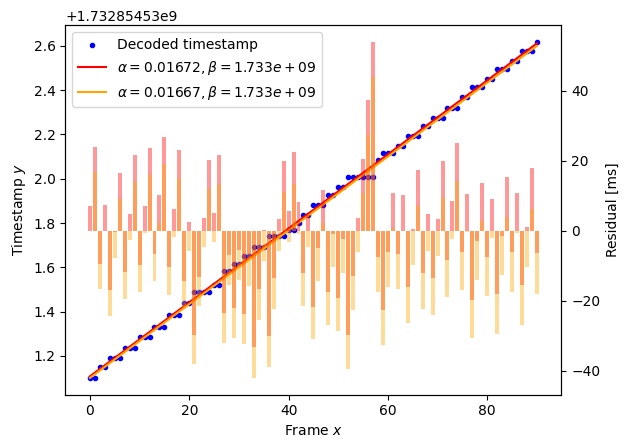

timestamp = 0.016715703247496803 * frame + 1732854531.1071339, rmse=16.241800142471757
timestamp = 0.016666666666666666 * frame + 1732854531.1, rmse=18.78046340491518


In [8]:
from datetime import datetime
import numpy as np

# fitting (both fps and offset)
ret = sp.stats.linregress(X, Y)

# fitting error in millisecond
E = ((np.array(X) * ret.slope + ret.intercept) - np.array(Y)) * 1000.0

# fitting (fixed fps)
offset, alpha, beta, rmse = pycalib.estimate_offset(X, Y, fps=FPS)
E2 = ((np.array(X) * alpha + beta[0]) - np.array(Y)) * 1000.0

plt.figure()
plt.scatter(X, Y, marker='.', color='blue', label='Decoded timestamp')
plt.plot(X, np.array(X) * ret.slope + ret.intercept, color='red', label=rf'$\alpha={ret.slope:.4}, \beta={ret.intercept:.4}$')
plt.plot(X, np.array(X) * alpha + beta[0], color='orange', label=rf'$\alpha={alpha:.4}, \beta={beta[0]:.4}$')
plt.xlabel(r'Frame $x$')
plt.ylabel(r'Timestamp $y$')
plt.legend()
ax2 = plt.gca().twinx()
ax2.bar(X, E, color='red', alpha=0.4)
ax2.bar(X, E2, color='orange', alpha=0.4)
ax2.set_ylabel('Residual [ms]')
plt.show()

print(f'timestamp = {ret.slope} * frame + {ret.intercept}, rmse={np.sqrt(np.mean(E**2))}')
print(f'timestamp = {alpha} * frame + {beta[0]}, rmse={np.sqrt(np.mean(E2**2))}')


## 4. Multi-camera time synchronization

Suppose we have three videos $V_1$, $V_2$, and $V_3$ running at a same framerate, and we need to translate the frame index $x_c$ of $V_c$ to that of the others.

Assuming that the burn-in timestamps $y$ of the videos are from a single reference clock, we can simply formulate their relationship as

$$ y = \alpha x_1 + \beta_1 = \alpha x_2 + \beta_2 = \alpha x_3 + \beta_3 \,,$$

where $\alpha$ is shared by the cameras (because they run at the same framerate) while $\beta_c$ is a camera-specific offset (in second).  By stacking up the detected timestamps, we can rewrite this as a system of linear equations of the form

$$ \begin{bmatrix} x_1^{(1)} & 1 & 0 & 0 \\ \vdots & \vdots & \vdots & \vdots \\ x_1^{(N_1)} & 1 & 0 & 0 \\ x_2^{(1)} & 0 & 1 & 0 \\ \vdots & \vdots & \vdots & \vdots \\ x_2^{(N_2)} & 0 & 1 & 0 \\ x_3^{(1)} & 0 & 0 & 1 \\ \vdots & \vdots & \vdots & \vdots \\ x_3^{(N_3)} & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \alpha \\ \beta_1 \\ \beta_2 \\ \beta_3 \end{bmatrix} = \begin{bmatrix} y_1^{(1)} \\ \vdots \\ y_1^{(N_1)} \\ y_2^{(1)} \\ \vdots \\ y_2^{(N_2)} \\ y_3^{(1)} \\ \vdots \\ y_3^{(N_3)} \end{bmatrix} \,,$$

where $x_{c}^{(i)}$ is the frame index $i$ of camera $c$ at which timestamp $y_{c}^{(i)}$ was detected.

Once estimated $\alpha$ and $\beta_c$, the offset in frame between the cameras are given as

$$ x_{c'} = x_c + o_{c,c'}, \quad o_{c,c'} = \frac{\beta_c - \beta_{c'}}{\alpha} \,.$$

`pycalib.estimate_offset()` solves this system and returns $o_{0,c}$, $\alpha$, $\beta_c$, and RMSE for each camera.  That is, by shifting the frame index using $o_{0,c}$, we can translate the frame indices between the cameras.


In [11]:
import numpy as np

SRC = ['../data/qrtimecode/sample-1.mp4', 
       '../data/qrtimecode/sample-2.mp4', 
       '../data/qrtimecode/sample-3.mp4' ]

X_ALL = []
Y_ALL = []
F_ALL = []
for s in SRC:
    X, Y, F = pycalib.detect_qrcode_gopro(s, verbose_lv=1)
    X_ALL.append(X)
    Y_ALL.append(Y)
    F_ALL.append(F)


assert np.all(np.array(F_ALL) == F_ALL[0]), f'framerate mismatch: {F_ALL}'

#offset, alpha, beta, rmse = pycalib.estimate_offset(X_ALL, Y_ALL, fps=F_ALL[0])
offset, alpha, beta, rmse = pycalib.estimate_offset(X_ALL, Y_ALL)
print(f'offset = {offset}')
print(f'alpha  = {alpha}')
print(f'beta   = {beta}')
print(f'rmse   = {rmse}')


Found in 158 frames: 100%|████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 65.23it/s]

offset = [  0.         219.29837973 507.75852053]
alpha  = 0.016640241631476503
beta   = [1.73292871e+09 1.73292871e+09 1.73292872e+09]
rmse   = [0.01078204 0.01021436 0.00965547]


## Notes

Again, this time synchronization estimates relative offsets between frame indices of multiple videos.  The offsets are given as floating-point numbers, meaning that the "corresponding" frames are off by subframes.  In order to get frames that are exactly synchronized, i.e. that their exposures start at exactly the same time, we need to use a trigger or genlock signal.

- If your cameras run at different framerates, such as 30fps and 60fps, you can simply align their frame indices by scaling them according to their ratio.  That is, the frame index $x$ of a 30fps camera should be converted as $2 x$ of a 60fps camera.
  - Pay attention to the actual framerate. For example, some cameras capture at 59.94fps while advertising it as 60fps.
- This implementation does not account for frame drops (not "Drop Frames").  If your camera silently drops a frame, the estimated offset becomes invalid for the remaining frames.  Though it is not trivial to detect / estimate the exact timing of a frame drop, we can detect the occurrence of such an event if we have QR codes before and after the main recording.
  - For better time synchronization, [record LTC in the audio channel](https://gopro.github.io/labs/control/ltc/).
